# Notebook de Debugger do BERT

Este notebook serve como debugger da arquitetura da rede uma vez que a rede utilizada éa **mesma** que a apresentada [neste notebook](estudo-bert.ipynb). A única diferença é em relação aos dados utilizados, que são totalmente dummies

In [1]:
!nvidia-smi

Mon Dec 21 18:27:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   34C    P0    34W / 250W |      0MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import sys
sys.path.append('..')

In [3]:
from code_utils.metrics import decode_text, generate_sequences, report_linguistic_metrics
from code_utils.models.bert.training import define_decoder_tokenization_layers, define_full_model, tokenize_encoder
from code_utils.models.bert.inference import encoder_inference_model, decoder_inference_model
from code_utils.preprocessing.data_preprocessing import process_data

[nltk_data] Downloading package wordnet to
[nltk_data]     /var/fasttmp/abarbosa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
import random
from random import randint
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Attention, Bidirectional, Dense, Embedding, Input, GRU
from tensorflow.keras.utils import plot_model
from transformers import TFBertModel
import pandas as pd

In [5]:
SEED = 42
random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)
START_TOKEN='xxstart'
END_TOKEN='xxend'

In [6]:
# generate a sequence of random integers
def generate_sequence(length, n_unique):
	return [randint(1, n_unique-1) for _ in range(length)]
# prepare data for the LSTM
def get_dataset(n_in, n_out, cardinality, n_samples):
    X1, X2, y = list(), list(), list()
    for _ in range(n_samples):
        # generate source sequence
        source = generate_sequence(n_in, cardinality)
        # define padded target sequence
        target = source[:n_out]
        target.reverse()
        # create padded input target sequence
        target_in = [START_TOKEN] + target+[END_TOKEN]
        target = target+[END_TOKEN]
        # store
        X1.append(' '.join(np.array(source).astype('str')))
        X2.append(' '.join(np.array(target_in).astype('str')))
        y.append(' '.join(np.array(target).astype('str')))
    return np.reshape(np.array(X1), (-1,1)),np.reshape(np.array(X2), (-1,1)),np.reshape(np.array(y), (-1,1))
# configure problem
n_features = 50 + 1
n_steps_in = 20
n_steps_out = 5

In [7]:
encoder_train, decoder_train, decoder_label_train = get_dataset(n_steps_in, n_steps_out, n_features, 100000)
encoder_test, decoder_test, decoder_label_test = get_dataset(n_steps_in, n_steps_out, n_features, 10000)

In [8]:
ENCODER_SEQ_LENGTH = 20
DECODER_SEQ_LENGTH = 5

In [9]:
(
    tokenizer_layer_decoder,
    tokenizer_layer_decoder_inference
) = define_decoder_tokenization_layers(decoder_train, DECODER_SEQ_LENGTH)

In [10]:
VOCAB_SIZE_decoder = len(tokenizer_layer_decoder.get_vocabulary()) + 2
BATCH_SIZE = 128
EPOCHS=50
EMBED_DIM = 64  # tamanho do Embedding de cada token
BERT_DIM = 768
BERT_MODEL_NAME = "neuralmind/bert-base-portuguese-cased"
LEARNING_RATE=1e-5

In [11]:
encoder_train = tokenize_encoder(
    encoder_train, BERT_MODEL_NAME, ENCODER_SEQ_LENGTH
)
encoder_test =tokenize_encoder(
    encoder_test, BERT_MODEL_NAME, ENCODER_SEQ_LENGTH
)

In [12]:
# Encoder definition
input_text_encoder = Input(
    shape=(ENCODER_SEQ_LENGTH,), dtype=tf.int32, name="input_text"
)
encoder_model = TFBertModel.from_pretrained(
    BERT_MODEL_NAME,
    output_hidden_states=False,
    output_attentions=False,
    from_pt=True,
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

In [13]:
# Decoder definition
input_text_decoder = Input(shape=(None,), dtype=tf.string, name="decoder_input")
emb_dec_layer = Embedding(VOCAB_SIZE_decoder, EMBED_DIM, name="decoder_embedding")
decoder_model = GRU(
    BERT_DIM, return_sequences=True, return_state=True, name="decoder_rnn"
)
attention_layer = Attention(name="attention", causal=True)
decoder_dense = Dense(VOCAB_SIZE_decoder, activation="softmax", name="dense_layer")

In [14]:
## Preprocessing step
tokenized_decoder = tokenizer_layer_decoder(input_text_decoder)
# embedding layer
dec_emb = emb_dec_layer(tokenized_decoder)

In [15]:
model =  define_full_model(input_text_encoder,encoder_model,
                           input_text_decoder,
                           dec_emb, decoder_model,
                           attention_layer, decoder_dense
                      )

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
decoder_vectorizer (TextVectori (None, 5)            0           decoder_input[0][0]              
__________________________________________________________________________________________________
input_text (InputLayer)         [(None, 20)]         0                                            
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, 5, 64)        3456        decoder_vectorizer[0][0]         
______________________________________________________________________________________________

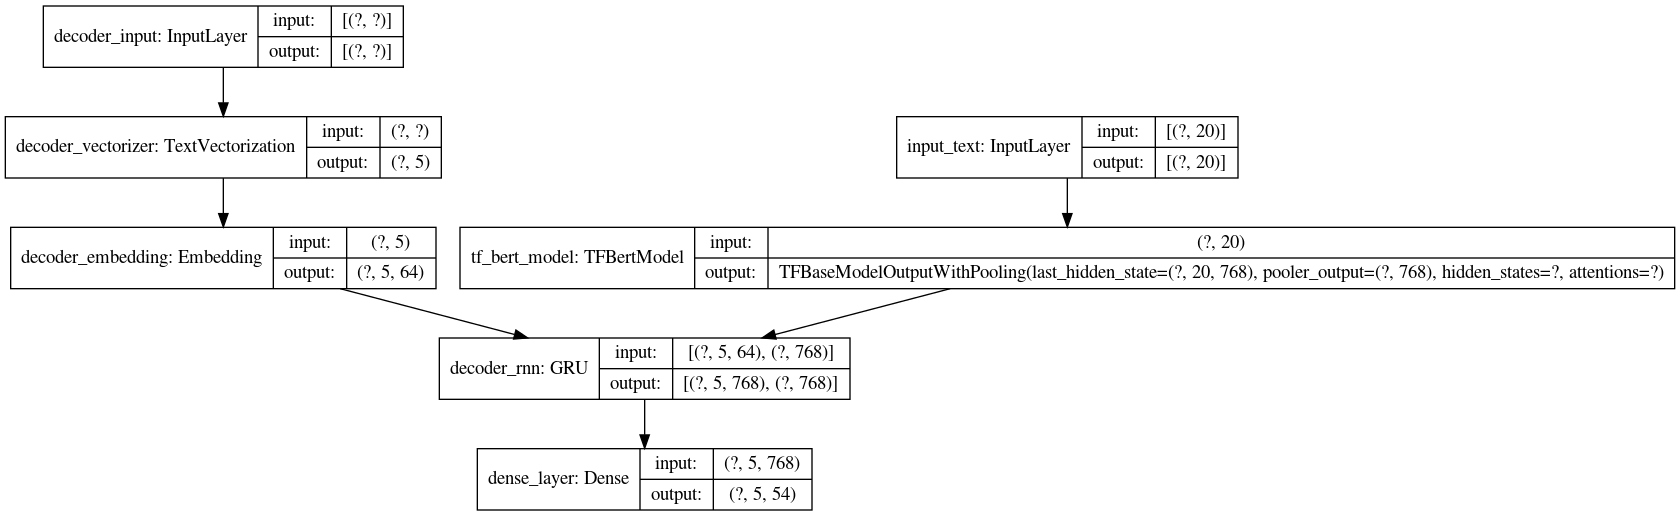

In [17]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [18]:
opt = tf.keras.optimizers.Adam(LEARNING_RATE)
model.compile(
    optimizer=opt,
    loss={"dense_layer": "sparse_categorical_crossentropy"},
    metrics={"dense_layer": "accuracy"},
)

In [19]:
print(f"Forma do Dataset de Treinamento: {encoder_train.shape}")

Forma do Dataset de Treinamento: (100000, 20)


In [ ]:
my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=2)]

history = model.fit(
    [encoder_train, decoder_train],
    tokenizer_layer_decoder(decoder_label_train),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=my_callbacks,
    validation_split=0.1
)

Epoch 1/50
704/704 [==============================] - 143s 204ms/step - loss: 2.9702 - accuracy: 0.1985 - val_loss: 1.9151 - val_accuracy: 0.2419
Epoch 2/50
704/704 [==============================] - 141s 200ms/step - loss: 1.8350 - accuracy: 0.2397 - val_loss: 1.6236 - val_accuracy: 0.2663
Epoch 3/50
704/704 [==============================] - 141s 200ms/step - loss: 1.6637 - accuracy: 0.2791 - val_loss: 1.4924 - val_accuracy: 0.3560
Epoch 4/50
704/704 [==============================] - 141s 200ms/step - loss: 1.5035 - accuracy: 0.3648 - val_loss: 1.3103 - val_accuracy: 0.4507
Epoch 5/50
704/704 [==============================] - 141s 200ms/step - loss: 1.3284 - accuracy: 0.4441 - val_loss: 1.1420 - val_accuracy: 0.5301
Epoch 6/50
704/704 [==============================] - 141s 200ms/step - loss: 1.1748 - accuracy: 0.5113 - val_loss: 0.9963 - val_accuracy: 0.6115
Epoch 7/50
704/704 [==============================] - 141s 200ms/step - loss: 1.0374 - accuracy: 0.5759 - val_loss: 0.8640 -

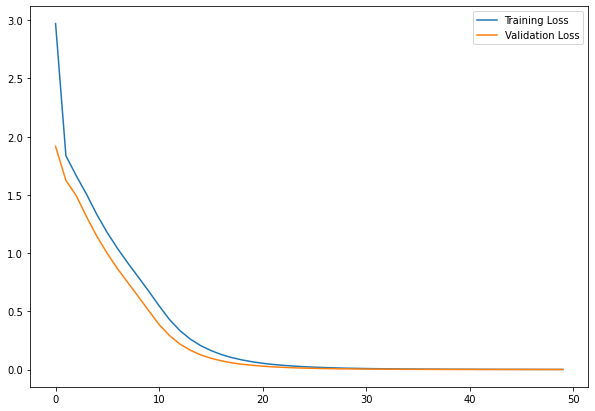

In [26]:
plt.figure(figsize=(10,7))
a, = plt.plot(history.history['loss'],label='Training Loss')
b, = plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend(handles=[a,b])
plt.show()

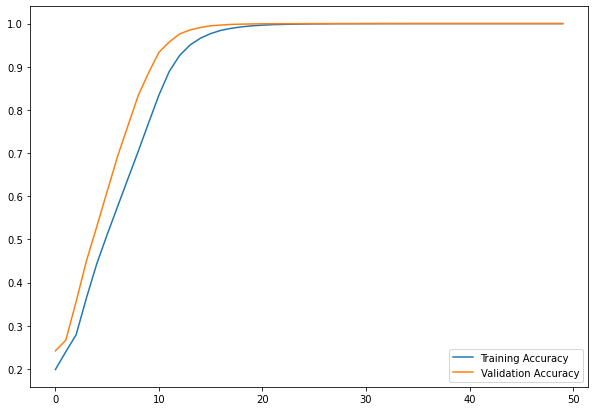

In [28]:
plt.figure(figsize=(10,7))
a, = plt.plot(history.history['accuracy'],label='Training Accuracy')
b, = plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.legend(handles=[a,b])
plt.show()

In [30]:
test_loss, test_acc = model.evaluate([encoder_test, decoder_test],
                                      tokenizer_layer_decoder(decoder_label_test),
                                      batch_size=128)

79/79 [==============================] - 6s 75ms/step - loss: 4.0673e-04 - accuracy: 1.0000


In [32]:
tokenized_decoder_inference = tokenizer_layer_decoder_inference(input_text_decoder)
dec_emb_embedding_inference = emb_dec_layer(tokenized_decoder_inference)

In [34]:
encoder_inference = encoder_inference_model(input_text_encoder, encoder_model)

In [36]:
decoder_inference = decoder_inference_model(
    decoder_embedding=dec_emb_embedding_inference,
    target_text=input_text_decoder,
    latent_dim=BERT_DIM,
    encoder_sequence_length=ENCODER_SEQ_LENGTH,
    decoder_model=decoder_model,
    attention_layer=attention_layer,
    decoder_dense=decoder_dense,
)

In [37]:
sentences = generate_sequences(
    encoder_test,
    decoder_label_test,
    100,
    encoder_inference,
    decoder_inference,
    DECODER_SEQ_LENGTH,
    tokenizer_layer_decoder_inference,
)

Gerando Predições: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


In [38]:
sentences.head()

,target_processed,predicted
3099,[25 19 42 19 43 xxend],25 19 42 19 43
6278,[15 48 45 1 32 xxend],15 48 45 1 32
8392,[16 18 2 11 17 xxend],16 18 2 11 17
3104,[44 41 41 37 19 xxend],44 41 41 37 19
7215,[30 8 37 32 39 xxend],30 8 37 32 39


In [39]:
bleu_metric, nist_metric, meteor_metric = report_linguistic_metrics(sentences)

In [40]:
pd.DataFrame([test_acc, bleu_metric, nist_metric, meteor_metric]).T.rename(columns={0:'accuracy',
                                                                                    1:'bleu score',
                                                                                    2:'nist score',
                                                                                    3:'meteor score'})

,accuracy,bleu score,nist score,meteor score
0,1.0,0.631651,5.859829,0.844068
